# Comparing the performance of Neural networks and Gradient boosted trees  , and a stacked ensemble of both in MHC class I binding prediction


---
### Background

The prediction of MHC peptide binding is an important problem in immunology. Data driven methods give best performance for this task because of complexity of the MHC molecules and the binding process. The most successful machine learning models are Artificial Neural Networks in this area.  I have seen articles describing SVM models, but nobody has tried gradient boosted trees (as far as I know).


In the last years a lot of Data Science competitions were won with a framework called Gradient Boosted Trees, especially and implementtion called XGBoost. These models very frequently outperform neural networks in general machine learning tasks. 

These facts gave me the idea to compare the perfomance of  Neural networks  and Gradient boosted trees and in MHC class I peptide binding prediction.

Neural networks and Gradient boosted trees are very different models, therefore ensembling them can give another boost to performance.


----
### Data

#### Source
I have downloaded MHC class I peptide binding data which has been used in this benchmark article ( http://www.ncbi.nlm.nih.gov/pubmed/25017736)  from the IEDB website.


#### Encoding 

Input data is very simply coded as the folowing:
- zero padded sequences to the longest peptide length
    - state of the art models use more sophisticated prediction on different length peptides, but for demonstration purpose I didn't want to recreate those.
- amino acids are encoded in a one hot scheme, or Blosum encoding
- original peptide lengths are included

#### Target 

I predict IC50 binding data transformed as the following (from netmhc articles):

$y = 1 - \log_{10}(IC50)/ \log_{10}(50000)$


---

### Models

#### Neural network

I use a neural network architecture similar to the one used in NetMHC.
- 1 hidden layer
- 5 units in the hidden layer
- tanh activations for hidden layer, sigmoid for the final layer, these are only guesses I have found no description of activation in NetMHC arrticles.

I use the Keras library. http://keras.io


#### Gradient boosted trees
Some resources about the model:
- http://xgboost.readthedocs.org/en/latest/model.html
- http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf
    
I used the XGBoost software library. http://xgboost.readthedocs.org/en/latest/


#### Ensembling

I simply used the mean of different predictions, as described in several NetMHC articles.

---

### Methods


I have done nested 5-fold cross validation evaluations. All models use early stopping on validation data. Validation data is a random10% subset of the 4 folds of traning data.

The folds used were defined in the benchmark article as the group similarity (cv_gs) folds.



--- 

### Conclusions


The Gradient Boosted Trees outperforms Neural Networks. The ensemble of these 2 models adds a further improvement.

Note that my NN ensemble perform significantly worse than NetMHC. It can be because of the treatment of different peptide lengths, or other differences between the my ensemble and NetMHC. I'm not sure about this.


---


### Future Work

#### Adding Gradient Boosted trees to the NetMHC ensemble

I think adding Gradient Boosted trees to the NetMHC ensemble could further imporove its peforance as demonstrated in the notebook.


#### Further ideas for improvement:

- Hypterparameter optimization for xgb
- Sophisticated handling of different length peptides, see literature.
- Different NN architectures for alleles with different number of training data available.
- Get the MHC pseudosequence data and repeat the comparison with netmhcpan.
- (More realistic random peptides.)




----
#### Notes

- To run this notebook you need to 
    - download the dataset
    - and have keras,theno,xgboost,sklearn,pandas,numpy installed
    - see the docker image for a ready enviroment
    
    
    
- This notebook can be run as it is. Just click run all. 
    - It takes some time but on a stronger computer it should be less than 30 minutes.
    
- It takes several hours to run this notebook!


----


This notebook was created by Dezso Ribli

### Load modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#go to working dir
import os

Using Theano backend.


### Data Loader functions

In [2]:
def load_data(blosum=False):
    """Load train/blind test data as in the benchmark."""
    #load the cross validation data
    dataf='input/benchmark_mhci_reliability/binding/bd2009.1/bdata.2009.mhci.public.1.cv_gs.txt'
    data=pd.read_csv(dataf,sep='\t')
    
    #select only with length 8-12, anyway only those will be evauated
    data=data[(data.peptide_length >=8) & (data.peptide_length <12)]
     
    #encode amino acids
    X_seq=encode_seq(data.sequence.values,data.sequence.values,blosum)
    
    #stack columns
    X=np.column_stack([X_seq,data.peptide_length.values])
    
    #make target variable
    y = 1 - np.log10(data.meas)/np.log10(50000)
    data['meas_tf']= y
    
    #make a label target in the dataframe for binding
    label=np.ones(len(data.meas))
    label[data.meas.values>=500]=0
    data['label']=label

    #permute arrays
    rng=np.random.RandomState(42)
    perm=rng.permutation(len(X))
    X,y,data=X[perm],y[perm],data.iloc[perm,:].reset_index(drop=True)
    
    return X,y,data


def encode_seq(x_all,x_in,blosum):
    """Encode string amino acid sequences to numbers."""
    if blosum:
        return encode_seq_blosum(x_all,x_in)
    else:
        return encode_seq_one_hot(x_all,x_in)

def encode_seq_one_hot(x_all,x_in):
    """Encode string amino acid sequences to numbers with one hot encoding."""
    #zero pad peptids to equal length
    x_temp_all=np.array([list(x.zfill(11)) for x in x_all])
    x_temp_in=np.array([list(x.zfill(11)) for x in x_in])
    
    lb = LabelBinarizer()
    lb.fit(x_temp_all.flatten())
    x_out=np.column_stack([lb.transform(x_temp_in[:,i]) for i in range(11)])

    return x_out

def encode_seq_blosum(x_all,x_in):
    """Encode string amino acid sequences to numbers with blosum encoding."""
    #zero pad peptids to equal length
    maxlen=np.max(map(len,x_all))
    x_temp_all=np.array([list(x.zfill(11)) for x in x_all])
    x_temp_in=np.array([list(x.zfill(11)) for x in x_in])

    blosum62 = pd.read_csv('input/BLOSUM62.txt',header=None,skiprows=7,delim_whitespace=True,index_col=0)
    blosum_dict=blosum62.transpose().to_dict(orient='list')
    blosum_dict['0']=blosum_dict['*']
    
    #transform
    x_out=np.column_stack([[blosum_dict[x_temp_in[i,j]] for i in xrange(len(x_in)) ] for j in range(11)])

    return x_out



"""For netmhc results:"""

def load_all_tables(path):
    """Load all tables in directory and concat them into one big table"""
    return pd.concat([load_allele_table(f,all_from_fname(f)) for f in glob.glob(path)])

def load_allele_table(fname,allele):
    """Load a result table and annotate with allele"""
    #note they are .xls but csv files...
    tmp_table=pd.read_csv(fname,sep='\t')
    tmp_table['mhc']=allele.replace('_','-')
    tmp_table['peptide_length']=[len(x) for x in tmp_table.sequence]
    tmp_table['label']=(tmp_table.meas <= np.log10(500)).astype('int')
    tmp_table['pred_tf']=1-tmp_table.pred.values/np.log10(50000)
    return tmp_table


def all_from_fname(fname):
    """Get allele from the filename"""
    # a bit convoluted naming
    return '_'.join(os.path.basename(fname).split('cv_gs.')[-1].split('.')[0].split('-')[:-1])

### Functions for adding random peptides to training data

In [3]:
def create_all_random_peptides(x_in):
    #create random peptides
    random_peptides,lengs=[],[]
    for i in xrange(8,12):
        for j in xrange(25):
            random_peptides.append(create_random_peptide(i))
            lengs.append(i)

    #encode amino acids
    if x_in.size==232:
        X_seq=encode_seq(random_peptides,random_peptides,blosum=False)
    else:
        X_seq=encode_seq(random_peptides,random_peptides,blosum=True)
    
    #stack columns
    X=np.column_stack([X_seq,lengs])
    
    #return a binding too
    y= 0.1 *np.random.random(len(random_peptides))
        
    return X,y

def create_random_peptide(leng):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P','Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    return ''.join(np.random.choice(aa) for _ in range(leng))

----


### Cross validation scheme for both models


In [4]:
def cv_gs(fitter,model_spec,X,y,data,add_random_peptides=True,**kwargs):
    """Evaluate XGB model with cross validation."""
    #result
    y_pred=np.zeros(len(y))
    #loop folds
    for i in xrange(5):
        #select folds
        test_idx=data.cv.values==i
        train_idx=~( test_idx)
        
        if add_random_peptides:
            #add random peptides
            rx,ry=create_all_random_peptides(X[0])
            X_train=np.concatenate([X[train_idx],rx])
            y_train=np.concatenate([y[train_idx],ry])

            #permute arrays
            rng=np.random.RandomState(42)
            perm=rng.permutation(len(X_train))
            X_train,y_train=X_train[perm],y_train[perm]
        else:
            X_train,y_train=X[train_idx],y[train_idx]
        
        #train and predict
        y_pred[test_idx]=fitter(model_spec,
                                  X_train,y_train,
                                  X[test_idx],**kwargs)
    return y_pred


def nn_fit(get_model,X_train,y_train,X_test,
                      patience=10,nb_epoch=100,**kwargs):
    """Fit model on train test set with early stopping."""
    #get model
    model=get_model(X_train.shape[1])
    
    #callbacks
    best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=0)
    early_stop=EarlyStopping(patience=patience,verbose=0)
    
    #train it
    model.fit(X_train,y_train,nb_epoch = nb_epoch,validation_split=0.1,
              callbacks=[best_model,early_stop],verbose=0,**kwargs)
    
    #load best model and predict
    model.load_weights('best_model')
    y_pred_test=model.predict(X_test).ravel()
    
    return y_pred_test

def xgb_fit(params,X_train,y_train,X_test,
                    num_boost_round=20000,verbose_eval=False,
                    early_stopping_rounds=1000,validation_size=0.1):
    """Fit model on train test set with early stopping."""
    #set seed to get randomized results
    params['seed']=np.random.randint(low=0,high=1000)
    
    #split validation data for early stopping
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_size)
    
    #convert to data format for xgb
    dtrain = xgb.DMatrix( X_train, label=y_train)
    dvalid = xgb.DMatrix( X_valid, label=y_valid)
    dtest = xgb.DMatrix( X_test )
    
    #define printed evaluations
    evallist  = [(dtrain,'train'),(dvalid,'eval')]

    #lets train
    bst = xgb.train(params,dtrain,evals=evallist,
                    num_boost_round=num_boost_round,
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=verbose_eval)
    
    #make predictions
    y_pred_test=bst.predict(dtest)
    
    return y_pred_test

### Funcions to train ensemble models

In [5]:
def mean_ensemble(X,X_blosum,y,data,fitter,model,n_sparse=10,n_blosum=10):
    """Train an ensemble of models, make prediction using mean."""
    #train sparse models
    cv_preds_sparse=[cv_gs(fitter,model,X,y,data) for i in xrange(n_sparse) ]

    #train blosum models
    cv_preds_bls=[cv_gs(fitter,model,X_blosum,y,data) for i in xrange(n_blosum)]
        
    #create final prediction from the mean of predictions
    final_preds=np.array(cv_preds_sparse+cv_preds_bls).mean(axis=0)
    
    return final_preds

### Define the details of single models

In [6]:
def mhc_net(input_dim,n_dense=5):
    """
    Create a Keras model similar to netmhc networks.
    
    Activations were selected after some trials. I dont know what netmhc uses.
    """
    
    model = Sequential()
    model.add(Dense(n_dense, input_dim=input_dim,activation='tanh'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


#xgboost model params
xgb_params = {'max_depth':5,
         'eta':0.005,
         'min_child_weight':10,
         'colsample_bytree':0.7,
         'subsample':0.8,
         'silent':1,
         'objective': "reg:linear",
         'eval_metric': 'rmse',
         'nthread':4}

### Load data

In [7]:
X,y,data=load_data()
X_bls,y,data=load_data(blosum=True)
netmhc_cv_res=load_all_tables('input/benchmark_mhci_reliability/predictions/cv_gs/netmhc/*')

### Function to select one allele

In [8]:
def select_allele(allele,X,X_bls,y,data,netmhc_cv_res):
    """Return data from only one allele"""
    #index
    all_idx=(data.mhc==allele).values
    #X
    X_tmp=X[all_idx]
    X_tmp_bls=X_bls[all_idx]
    #y
    y_tmp=y[all_idx]
    #additional data
    data_tmp=data[all_idx]
    #netmhc preds
    netmhc_tmp=netmhc_cv_res[all_idx]
    return all_idx,X_tmp,X_tmp_bls,y_tmp,data_tmp,netmhc_tmp

### Predict all alleles
- This takes long long time

In [9]:
res_data=pd.DataFrame(data,copy=True)
for allele in np.unique(data.mhc.values):
    #select allele
    all_idx,X_tmp,X_tmp_bls,y_tmp,data_tmp,netmhc_tmp=select_allele(allele,X,X_bls,y,data,netmhc_cv_res)

    #nn ensemble
    nn_pred=mean_ensemble(X_tmp,X_tmp_bls,y_tmp,data_tmp,nn_fit,mhc_net,n_sparse=10,n_blosum=10)
    #xgb ensemble
    xgb_pred=mean_ensemble(X_tmp,X_tmp_bls,y_tmp,data_tmp,xgb_fit,xgb_params,n_sparse=1,n_blosum=1)
    #nn+xgb
    nn_xgb_pred=np.array(np.concatenate([[nn_pred],[xgb_pred]])).mean(axis=0)
    
    #save preds
    res_data.loc[all_idx,'nn']=nn_pred
    res_data.loc[all_idx,'xgb']=xgb_pred
    res_data.loc[all_idx,'nn_xgb']=nn_xgb_pred
    
    print allele,

H-2-Db H-2-Dd H-2-Kb H-2-Kd H-2-Kk H-2-Ld HLA-A-0101 HLA-A-0201 HLA-A-0202 HLA-A-0203 HLA-A-0206 HLA-A-0211 HLA-A-0212 HLA-A-0216 HLA-A-0219 HLA-A-0250 HLA-A-0301 HLA-A-1101 HLA-A-2301 HLA-A-2402 HLA-A-2403 HLA-A-2501 HLA-A-2601 HLA-A-2602 HLA-A-2603 HLA-A-2902 HLA-A-3001 HLA-A-3002 HLA-A-3101 HLA-A-3201 HLA-A-3301 HLA-A-6801 HLA-A-6802 HLA-A-6901 HLA-A-8001 HLA-B-0702 HLA-B-0801 HLA-B-0802 HLA-B-0803 HLA-B-1501 HLA-B-1502 HLA-B-1503 HLA-B-1509 HLA-B-1517 HLA-B-1801 HLA-B-2703 HLA-B-2705 HLA-B-3501 HLA-B-3801 HLA-B-3901 HLA-B-4001 HLA-B-4002 HLA-B-4402 HLA-B-4403 HLA-B-4501 HLA-B-4601 HLA-B-4801 HLA-B-5101 HLA-B-5301 HLA-B-5401 HLA-B-5701 HLA-B-5801 HLA-B-7301 Mamu-A-01 Mamu-A-02 Mamu-A-11 Mamu-A-2201 Mamu-B-01 Mamu-B-03 Mamu-B-08 Mamu-B-17 Patr-A-0101 Patr-A-0301 Patr-A-0401 Patr-A-0701 Patr-A-0901 Patr-B-0101 Patr-B-1301 Patr-B-2401


In [15]:
res_data.to_csv('all_specific_training_results_no_nestcv.csv',index=False)

## Results

In [11]:
"""
A bit convoluted way to aggregate in pandas dataframes on multiple columns with different column names,
but now it will be okay. I will look into this later maybe.
"""

def agg_auc_nn(group):
    return agg_auc(group,'nn')

def agg_auc_xgb(group):
    return agg_auc(group,'xgb')

def agg_auc_nn_xgb(group):
    return agg_auc(group,'nn_xgb')

def agg_auc_netmhc(group):
    return agg_auc(group,'pred_tf')

def agg_auc_netmhc_xgb(group):
    return agg_auc(group,'netmhc_xgb')


def agg_auc(group,col):
    y = group['label_x'].values
    pred = group[col].values
    
    if len(np.unique(y))==1:
        return 1
    else:
        return roc_auc_score(y,pred)

In [12]:
# merge with netmhc res
all_res=res_data.merge(netmhc_cv_res,on=['mhc','sequence'])

#add a netmhc xgb ensemble
all_res['netmhc_xgb']=0.5*(all_res.pred_tf+all_res.xgb)

## aggregate
grouped=all_res.groupby('mhc',as_index=False)

#get auc
all_auc_df=grouped.agg(agg_auc_nn)[['mhc']]
all_auc_df['counts']=grouped['mhc'].size().values
all_auc_df['nn']=grouped.agg(agg_auc_nn)[['cv']]
all_auc_df['xgb']=grouped.agg(agg_auc_xgb)[['cv']]
all_auc_df['nn_xgb']=grouped.agg(agg_auc_nn_xgb)[['cv']]
all_auc_df['netmhc']=grouped.agg(agg_auc_netmhc)[['cv']]
all_auc_df['netmhc_xgb']=grouped.agg(agg_auc_netmhc_xgb)[['cv']]

### Averaged results

In [13]:
print "NetMHC AUC:", all_auc_df['netmhc'].mean()
print "my nn mean AUC:", all_auc_df['nn'].mean()
print "my xgb mean AUC:", all_auc_df['xgb'].mean()
print "my nn+xgb mean AUC:", all_auc_df['nn_xgb'].mean()
print "NetMHC + xgb mean AUC:", all_auc_df['netmhc_xgb'].mean()

NetMHC AUC: 0.904293891309
my nn mean AUC: 0.897869533861
my xgb mean AUC: 0.907416522918
my nn+xgb mean AUC: 0.910406232264
NetMHC + xgb mean AUC: 0.914596805599


### Ensemble outperformed netmhc when the number of measurements were small

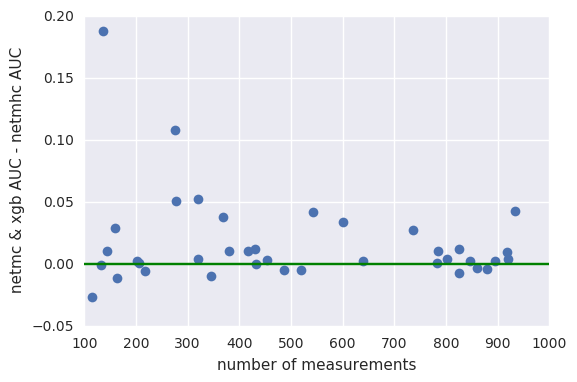

In [18]:
plt.plot(all_auc_df['counts'],all_auc_df['netmhc_xgb']-all_auc_df['netmhc'],'o')
plt.axhline(0,c='g')
plt.xlabel('number of measurements')
plt.ylabel(' netmc & xgb AUC - netmhc AUC')
_=plt.xlim(100,1000)